In [1]:
import glob
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch

# Load, join, filter the data

In [2]:
survival_info = pd.read_csv('/dataSRI/DataSets/BrATS/MICCAI_BraTS2020_TrainingData/survival_info.csv')

In [3]:
survival_info = survival_info.rename(columns={'Brats20ID': 'subj_id'})

In [4]:
with open('split_preprocessing/saved_ids.json', 'r') as f:
    split_data = json.load(f)

In [5]:
data = []
for train_id in split_data['train_ids']:
    data.append({
        'subj_id': train_id,
        'split': 'train',
    })
for val_id in split_data['val_ids']:
    data.append({
        'subj_id': val_id,
        'split': 'val',
    })
split_df = pd.DataFrame(data)

In [6]:
survival_info = survival_info.join(split_df.set_index('subj_id'), on='subj_id')

In [7]:
survival_features = []
survival_feature_files = glob.glob('data/models/unet_resize2/survival_features/result_dataset/survival_features_*.pt')
for fname in survival_feature_files:
    features = torch.load(fname, map_location='cpu')
    survival_features.append({
        'subj_id': features['subj_id'],
        'et_ratio': float(features['et_pred_size'] / features['whole_brain_size']),
        'tc_ratio': float(features['tc_pred_size'] / features['whole_brain_size']),
        'wt_ratio': float(features['wt_pred_size'] / features['whole_brain_size']),
        'et_ratio_gt': float(features['et_gt_size'] / features['whole_brain_size']),
        'tc_ratio_gt': float(features['tc_gt_size'] / features['whole_brain_size']),
        'wt_ratio_gt': float(features['wt_gt_size'] / features['whole_brain_size']),
    })
survival_feature_df = pd.DataFrame(survival_features)

In [8]:
features.keys()

dict_keys(['subj_id', 'whole_brain_size', 'et_pred_size', 'tc_pred_size', 'wt_pred_size', 'et_gt_size', 'tc_gt_size', 'wt_gt_size'])

In [9]:
survival_info = survival_info.join(survival_feature_df.set_index('subj_id'), on='subj_id')

In [10]:
# There's only one subject which didn't have an integer for Survival_days
# Not sure what's best, so I just removed this subject
survival_info = survival_info[~survival_info.Survival_days.str.startswith('ALIVE')]

In [11]:
survival_info

,subj_id,Age,Survival_days,Extent_of_Resection,split,et_ratio,tc_ratio,wt_ratio,et_ratio_gt,tc_ratio_gt,wt_ratio_gt
0,BraTS20_Training_001,60.463,289,GTR,train,0.033998,0.101025,0.218979,0.020282,0.031553,0.154112
1,BraTS20_Training_002,52.263,616,GTR,train,0.011757,0.032764,0.109355,0.004259,0.010043,0.042721
2,BraTS20_Training_003,54.301,464,GTR,val,0.007410,0.251932,0.147432,0.002272,0.002886,0.022807
3,BraTS20_Training_004,39.068,788,GTR,train,0.019238,0.051777,0.168525,0.009960,0.017252,0.066715
4,BraTS20_Training_005,68.493,465,GTR,val,0.016478,0.015750,0.087741,0.007525,0.010039,0.015161
...,...,...,...,...,...,...,...,...,...,...,...
231,BraTS20_Training_363,57.000,62,GTR,train,0.054188,0.065773,0.168061,0.033360,0.050576,0.086163
232,BraTS20_Training_366,72.000,633,GTR,train,0.035345,0.039631,0.085865,0.018090,0.021674,0.042272
233,BraTS20_Training_367,60.000,437,STR,train,0.020555,0.046078,0.177541,0.011445,0.012607,0.074254
234,BraTS20_Training_368,49.000,442,GTR,train,0.022956,0.038741,0.169104,0.011996,0.012951,0.059287


In [12]:
survival_info.groupby('split').agg('count')

,subj_id,Age,Survival_days,Extent_of_Resection,et_ratio,tc_ratio,wt_ratio,et_ratio_gt,tc_ratio_gt,wt_ratio_gt
split,,,,,,,,,,
train,179,179,179,101,179,179,179,179,179,179
val,56,56,56,27,56,56,56,56,56,56


In [13]:
survival_info.corr().style.background_gradient()

,Age,et_ratio,tc_ratio,wt_ratio,et_ratio_gt,tc_ratio_gt,wt_ratio_gt
Age,1.000000,0.053433,0.127236,-0.056229,0.080473,0.028964,0.021337
et_ratio,0.053433,1.000000,0.022369,0.582915,0.926300,0.956237,0.704178
tc_ratio,0.127236,0.022369,1.000000,0.256630,0.037469,0.010202,0.196067
wt_ratio,-0.056229,0.582915,0.256630,1.000000,0.560571,0.606419,0.814856
et_ratio_gt,0.080473,0.926300,0.037469,0.560571,1.000000,0.909249,0.713388
tc_ratio_gt,0.028964,0.956237,0.010202,0.606419,0.909249,1.000000,0.731247
wt_ratio_gt,0.021337,0.704178,0.196067,0.814856,0.713388,0.731247,1.000000


# Train and Evaluate a model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
import skorch
import skorch.dataset
from skorch import NeuralNetClassifier, NeuralNetRegressor
from skorch.helper import predefined_split

from sklearn.preprocessing import StandardScaler

In [16]:
import sklearn.metrics as metrics
import scipy.stats

In [56]:
train_mask = (survival_info.split == 'train')
val_mask = (survival_info.split == 'val')

In [57]:
X = np.stack([survival_info.Age, survival_info.et_ratio_gt, survival_info.tc_ratio_gt, survival_info.wt_ratio_gt]).T
X = X.astype(np.float32)
X_train = X[train_mask]
X_val = X[val_mask]

In [58]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [59]:
y = np.stack([survival_info.Survival_days.map(int)]).T
y = y.astype(np.float32)
y_train = y[train_mask]
y_val = y[val_mask]

In [60]:
num_inputs = X.shape[1]

In [61]:
class LogRMSE(nn.Module):
    def __init__(self):
        super(LogRMSE, self).__init__()
    
    def forward(self, y_pred, y):
        log_pred = torch.log(y_pred + 1)
        log_gt   = torch.log(y + 1)
        return torch.sqrt(torch.pow(log_pred - log_gt, 2).mean(dim=0))

In [62]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.slope = 0.0
        self.act_f = nn.LeakyReLU(self.slope)
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 64),
            self.act_f,
            nn.Linear(64, 64),
            self.act_f,
            nn.Linear(64,1),
        )
        self.init()
    
    def init(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.constant_(layer.bias, 500.)
        #nn.init.constant_(self.layers[-1].bias, 500.)
        
    def forward(self, X, **kwargs):
        return self.layers(X)


In [63]:
torch.manual_seed(2)

In [64]:
net = NeuralNetRegressor(
    SimpleModel,
    max_epochs=30,
    criterion=LogRMSE,
    lr=0.0003,
    optimizer=torch.optim.Adam,
    train_split=predefined_split(skorch.dataset.Dataset(X_val, y_val)),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)
net.initialize()

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SimpleModel(
    (act_f): LeakyReLU(negative_slope=0.0)
    (layers): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.0)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): LeakyReLU(negative_slope=0.0)
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  ),
)

In [65]:
_ = net.fit(X_train, y_train)

Re-initializing module.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.2824        1.4599  0.0832
      2        1.1245        1.3007  0.0165
      3        0.9635        1.1713  0.0137
      4        0.8801        1.1792  0.0097
      5        0.9434        1.1669  0.0188
      6        0.9153        1.1591  0.0108
      7        0.8724        1.1794  0.0107
      8        0.8718        1.1964  0.0147
      9        0.8843        1.1997  0.0106
     10        0.8847        1.1877  0.0107
     11        0.8758        1.1694  0.0147
     12        0.8676        1.1586  0.0466
     13        0.8703        1.1567  0.0277
     14        0.8758        1.1575  0.0402
     15        0.8738        1.1607  0.0378
     16        0.8688        1.1639  0.0480
     17        0.8681        1.1658  0.0386
     18        0.8628        1.1664  0.0317
     19        0.8678        1.1658  0.0201
     20        0.8673    

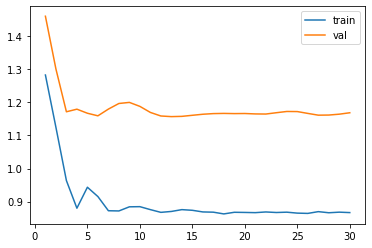

In [66]:
train_loss = [h['train_loss'] for h in net.history]
val_loss = [h['valid_loss'] for h in net.history]
epochs = [h['epoch'] for h in net.history]
plt.plot(epochs, train_loss, label='train')
plt.plot(epochs, val_loss, label='val')
plt.legend()

In [67]:
y_train_pred = net.predict(X_train)

In [68]:
y_val_pred = net.predict(X_val)

/dataSRI/MICHAELC/anaconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


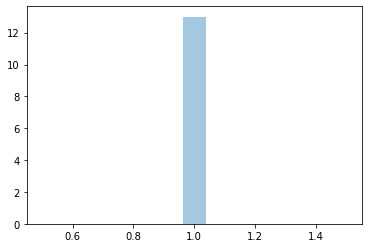

In [69]:
sns.distplot(convert(y_train_pred))

/dataSRI/MICHAELC/anaconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


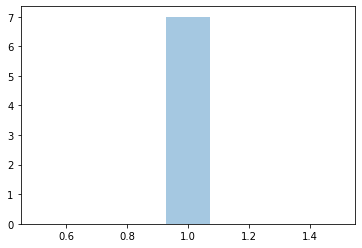

In [70]:
sns.distplot(convert(y_val_pred))

In [50]:
def convert(days, month_length=30.): 
    months = days / month_length
    classes = np.zeros_like(days, dtype=int)
    # 0 - short term (less than 10 months)
    classes[months < 10.] = 0
    # 1 - mid term (between 10 and 15 months)
    classes[(10. <= months) & (months <= 15.)] = 1
    # 2 - long term (more than 15 months)
    classes[months > 15.] = 2
    return classes
    
def compute_accuracy(pred_days, gt_days):
    # based on the quantization from the BraTS paper (https://arxiv.org/pdf/1811.02629.pdf)
    pred_classes = convert(pred_days)
    gt_classes = convert(gt_days)
    acc = (pred_classes == gt_classes).mean()
    return acc

In [51]:
compute_accuracy(y_train_pred, y_train)

0.27932960893854747

In [70]:
for ytp, pci in zip(y_train, gtc):
    print('{:.2f}, {}'.format(float(ytp) / 30, pci))

NameError: name 'gtc' is not defined

In [71]:
for ytp, pci in zip(y_train_pred, pc):
    print(ytp / 30, pci)

NameError: name 'pc' is not defined

In [72]:
SE_train = (y_train_pred - y_train)**2
SE_val = (y_val_pred - y_val)**2

measures = [
{
    'split': 'train',
    'accuracy': compute_accuracy(y_train_pred, y_train),
    'MSE': SE_train.mean(),
    'RMSE': np.sqrt(SE_train.mean()),
    'medianSE': np.median(SE_train),
    'MSLE': metrics.mean_squared_log_error(y_train_pred, y_train),
    'SpearmanR': scipy.stats.spearmanr(y_train_pred, y_train)
},
{
    'split': 'val',
    'accuracy': compute_accuracy(y_val_pred, y_val),
    'MSE': SE_val.mean(),
    'RMSE': np.sqrt(SE_val.mean()),
    'medianSE': np.median(SE_val),
    'MSLE': metrics.mean_squared_log_error(y_val_pred, y_val),
    'SpearmanR': scipy.stats.spearmanr(y_val_pred, y_val)
}, 
]
measures = pd.DataFrame(measures)
measures

,split,accuracy,MSE,RMSE,medianSE,MSLE,SpearmanR
0,train,0.279330,136943.53125,370.058807,31729.341797,0.753602,"(0.4176719642094151, 5.99081779089238e-09)"
1,val,0.160714,145023.34375,380.819305,39234.812500,1.365087,"(0.35345181134654824, 0.007535827660043265)"
